In [2]:
from numpy import asarray
from pandas import read_csv, to_datetime, DataFrame
import numpy as np
import pandas as pd

from statsmodels import api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from matplotlib import pyplot as plt
%matplotlib inline


In [3]:
# Reading the data
data = read_csv('Minor-project-group-by-hourly.csv')

# Adding a column for year to the data
data = data.assign(Year=2014)

# Creating a new column for time based on the values in the year, month, day and hours column
data['time'] = to_datetime(data[['Year', 'Month', 'Day', 'hours']])

# Dropping the unused columns
data = data.drop(columns=['Year', 'Month', 'Day', 'hours'])

# Renaming and rearranging the columns so that the time series is clean
data = data[['time', '0']]
data.columns = ['time', 'rides']

# Print the first 5 values to see the schema of the dataframe
data.head()

,time,rides
0,2014-04-01 00:00:00,138
1,2014-04-01 01:00:00,66
2,2014-04-01 02:00:00,53
3,2014-04-01 03:00:00,93
4,2014-04-01 04:00:00,166


C:\Users\gupta\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


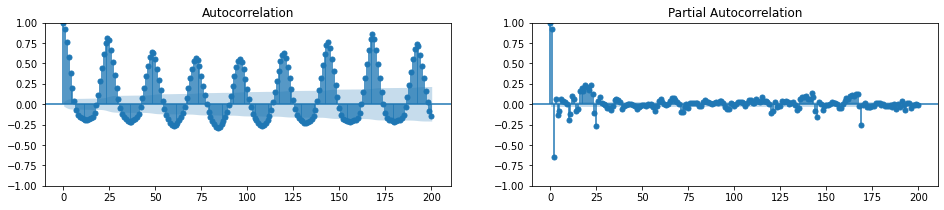

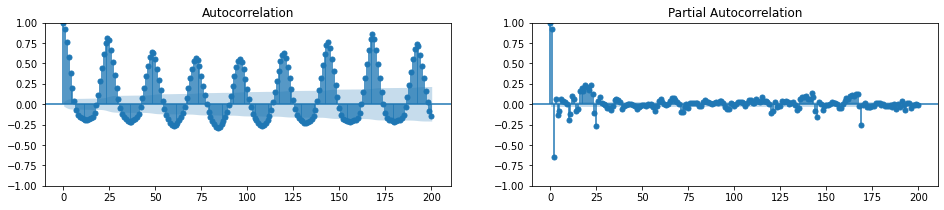

In [4]:
# Plotting the Autocorrelation and partial autocorrelation plots
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

# Autocorrelation measures the relationship between a variable’s current value and its past values.

# From the graph we can see that there is a strong positive relation between values every 24 hours.
# Also, we can see that the strongest correlation is at value 168 i.e. 24 x 7 (exactly 1 week apart)
plot_acf(data.rides.tolist(), lags=200, ax=axes[0])

plot_pacf(data.rides.tolist(), lags=200, ax=axes[1])

## Splitting the time series into training and test series

In [5]:
# We split the data into training and testing dataframes

train = data.iloc[: 24 * -30]
test = data.iloc[24 * -30 : ]

# Since the index of test data still starts from 3672, we reset the index and drop it. 
# This way, we can make the index start from zero
test = test.reset_index()
test = test.drop(columns=['index'])

print(data.shape, train.shape, test.shape)

(4391, 2) (3671, 2) (720, 2)


In [6]:
# We use the exponential smoothing approach to predict the future values of the number of trips.
# We are using the library function for this calculation

# parameters:
#     np.array(train['rides']) : This takes the 'rides' column from the datafram, and converts it into a numpy array, for easier calculation
#     seasonal_periods: The number of periods in a complete seasonal cycle, e.g., 4 for quarterly data or 7 for daily data with a weekly cycle. 240 is picked by trial and error
#     trend : The type of trend component. Add means that trend adds on to the seasonal part, and not multiplied by it.
#     seasonal : Same as trend

# calling the fit function will fit the training data to some parameters, and thus help us get the predictions

# model.forecast will forecast the value of the time series

model = ExponentialSmoothing(
    asarray(
        train['rides']
    ), 
    seasonal_periods=240,
    trend='add', 
    seasonal='add'
).fit()

prediction = model.forecast(len(test))

C:\Users\gupta\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [7]:
# Converting the numpy array to a time series dataframe, with same dates as test dataframe
prediction = DataFrame(prediction)

# Copying the time column to the prediction dataframe
prediction['time'] = test['time'].to_numpy()

# Renaming the prediction column as such
prediction.columns = ['prediction', 'time']

# Swapping the columns 
prediction = prediction[['time', 'prediction']]

prediction.head()

,time,prediction
0,2014-08-31 23:00:00,1020.663841
1,2014-09-01 00:00:00,794.432113
2,2014-09-01 01:00:00,620.727674
3,2014-09-01 02:00:00,543.780138
4,2014-09-01 03:00:00,564.462598


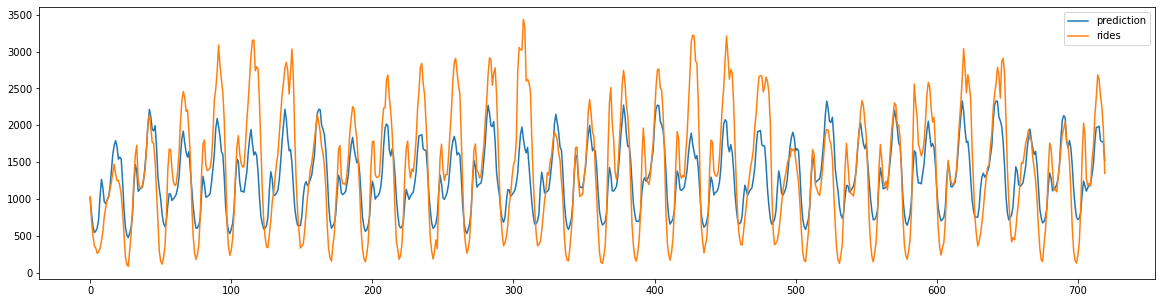

In [8]:
# Plotting the graph against the test dataframe

plt.figure(figsize=(20, 5))
prediction['prediction'].plot(legend=True)
test['rides'].plot(legend=True)

plt.show()

In [9]:
# For ARIMA
# value of p will be 2, d will be 0 and q will be 2
model = ARIMA(train['rides'], order=(0, 1, 2))
model_fit = model.fit()

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  rides   No. Observations:                 3671
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -24530.845
Date:                Sat, 04 Dec 2021   AIC                          49067.689
Time:                        14:46:28   BIC                          49086.313
Sample:                             0   HQIC                         49074.320
                               - 3671                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6660      0.011     62.222      0.000       0.645       0.687
ma.L2          0.2230      0.012     18.143      0.000       0.199       0.247
sigma2      3.743e+04    566.316     66.099      0.000    3.63e+04    3.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2641.80
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

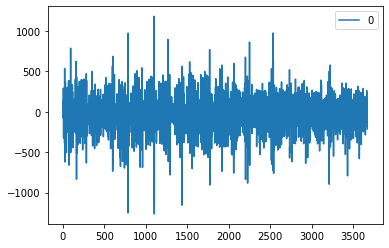

In [11]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

<AxesSubplot:ylabel='Density'>

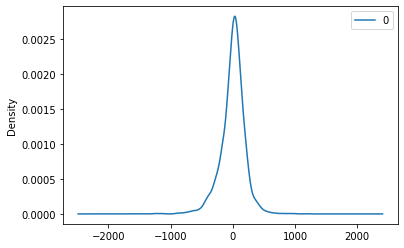

In [12]:
residuals.plot(kind='kde')

In [13]:
residuals.describe()

,0
count,3671.000000
mean,0.189952
std,193.491134
min,-1263.124999
25%,-88.042060
50%,18.106933
75%,107.633085
max,1183.240547


In [14]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(train['rides'], suppress_warnings=True)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3671
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -24530.845
Date:                Sat, 04 Dec 2021   AIC                          49067.689
Time:                        14:46:46   BIC                          49086.313
Sample:                             0   HQIC                         49074.320
                               - 3671                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6660      0.011     62.222      0.000       0.645       0.687
ma.L2          0.2230      0.012     18.143      0.000       0.199       0.247
sigma2      3.743e+04    566.316     66.099      0.000    3.63e+04    3.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2641.80
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
start = len(train)
end = len(data) - 1

prediction = model_fit.predict(start=start, end=end)
prediction = pd.DataFrame(prediction)
prediction['time'] = test['time'].to_numpy()
prediction.head()
prediction.columns = ['prediction', 'time']
prediction = prediction[['time', 'prediction']]
prediction.head()

,time,prediction
3671,2014-08-31 23:00:00,1260.291694
3672,2014-09-01 00:00:00,1213.272759
3673,2014-09-01 01:00:00,1213.272759
3674,2014-09-01 02:00:00,1213.272759
3675,2014-09-01 03:00:00,1213.272759


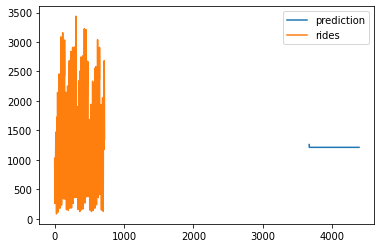

In [16]:
prediction['prediction'].plot(legend=True)
test['rides'].plot(legend=True)
plt.show()

In [17]:
sarimax = sm.tsa.statespace.SARIMAX(train['rides'], order=(2, 0, 2), seasonal_order=(2, 0, 2, 24 * 7))

result = model.fit()

In [18]:
prediction = result.predict(start=start, end=end)
# prediction = inverse_difference(X, prediction, 24)
prediction = pd.DataFrame(prediction)
prediction['time'] = test['time'].to_numpy()
prediction.columns = ['prediction', 'time']
prediction = prediction[['time', 'prediction']]
prediction.describe()

,prediction
count,720.000000
mean,1213.338063
std,1.752292
min,1213.272759
25%,1213.272759
50%,1213.272759
75%,1213.272759
max,1260.291694


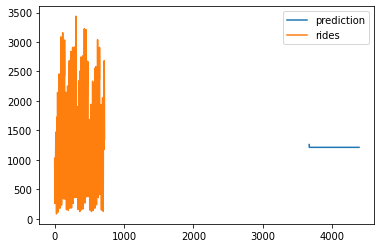

In [19]:
prediction['prediction'].plot(legend=True)
test['rides'].plot(legend=True)
plt.show()

In [20]:
prediction = pd.DataFrame(prediction)
prediction['time'] = test['time'].to_numpy()
prediction.columns = ['prediction', 'time']
prediction = prediction[['time', 'prediction']]
prediction.head()

,time,prediction
3671,1260.291694,2014-08-31 23:00:00
3672,1213.272759,2014-09-01 00:00:00
3673,1213.272759,2014-09-01 01:00:00
3674,1213.272759,2014-09-01 02:00:00
3675,1213.272759,2014-09-01 03:00:00


In [21]:
model = ExponentialSmoothing(
    np.asarray(data['rides']), 
    seasonal_periods=120, 
    trend='add', 
    seasonal='add'
).fit()

prediction = model.forecast(len(test))

In [22]:
prediction = pd.DataFrame(prediction)
prediction['time'] = test['time'].to_numpy()
prediction.columns = ['prediction', 'time']
prediction = prediction[['time', 'prediction']]
prediction.head()

,time,prediction
0,2014-08-31 23:00:00,994.417370
1,2014-09-01 00:00:00,676.084539
2,2014-09-01 01:00:00,534.193658
3,2014-09-01 02:00:00,479.750985
4,2014-09-01 03:00:00,564.140909


<AxesSubplot:>

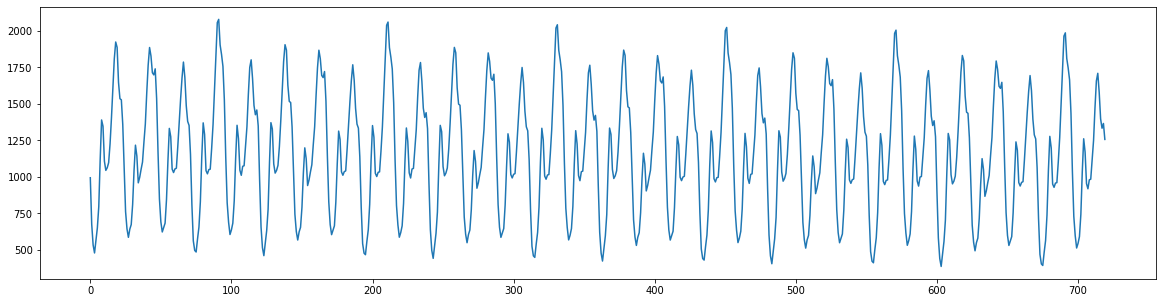

In [23]:
plt.figure(figsize=(20, 5))
prediction['prediction'].plot()